# Methodo :

- Dès l'import, on génère toute les calendar_class possible. Elles sont dans un dictionnaire T_labels.
- On génère aussi un dictionnaire 'D' où à chaque calendar-class est associé un dic_class2rpz/ dic_rpz2class
- Pour l'entrainement, on choisi T_labels[args.calendar_class]
- Pour la calibration, on choisi args.calibration_calendar_class. On a le choix de switcher à travers la calendar-class que l'on veut.

## Import

In [14]:
import pickle
import numpy as np 
import pandas as pd
import os 
import io 
import matplotlib.pyplot as plt

from utilities_DL import get_MultiModel_loss_args_emb_opts,load_init_trainer
from DL_class import MultiModelTrainer
from plotting_bokeh import generate_bokeh

from config import get_parameters
from paths import folder_path,file_name,save_folder
import torch


from QuanTraffic_method import get_QuanTraffic_calibration_table

## Choose the saved model : 
Here the 'best one', which mean the one on quantile loss with the smallest valid_loss. 

`Valid loss are not comparable for differents: `
-  K_fold
- fold
- single_station 
- dataset 
- validation


In [16]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [ ]:
# ===== Load Saved Best Model : Load Dataset, Trainer, dataloader ...
save_model_folder = f"{save_folder}best_models/"
model_perf_path = f"{save_model_folder}model_args.pkl"
model_perf = CPU_Unpickler(open(model_perf_path,'rb')).load()
#model_perf = pickle.load(open(model_perf_path,'rb'))
best_valid_loss = np.inf 
for trial in model_perf['model'].keys():

    valid_loss = model_perf['model'][trial]['performance']['valid_loss']
    loss_function  = model_perf['model'][trial]['args']['loss_function_type']
    if loss_function == 'quantile':
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_trial = trial

best_model = f"{save_model_folder}{best_trial}_best_model.pkl"
print(best_model)

# But, here a pretty good model for trained Fold1 is available: 

In [46]:
best_trial = '33224_STGCN_F6f0_256_500_011_03_06_2024'  #F6f0 mean it's the first fold trained, which correspond to the number1, cause the true 'f0' has been used for HP tuning ...
best_model = f'save/best_models/{best_trial}_best_model.pkl'

In [42]:
# ==== Update Some Parameters:
config = model_perf['model'][best_trial]['args']
config['abs_path'] = f"{os.path.abspath(os.getcwd())}/"
config['device'] = 'cuda:0' if torch.cuda.is_available() else 'cpu'
config['K_fold'] = 6
args = get_parameters(config)
# ==== ....

# ==== Load un-trained model: 
Datasets,DataLoader_list,dic_class2rpz,nb_words_embedding,time_slots_labels,dic_rpz2class = load_init_trainer(folder_path,file_name,args)
(loss_function,Model_list,Optimizer_list,Scheduler_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding,dic_class2rpz,n_vertex = len(Datasets[0].columns))
multimodeltrainer = MultiModelTrainer(Datasets,Model_list,DataLoader_list,args,Optimizer_list,loss_function,Scheduler_list,args_embedding=args_embedding,dic_class2rpz=dic_class2rpz,show_figure=False)
# ==== ....

# ==== Load Trained Weight:
saved_checkpoint =  torch.load(best_model) if torch.cuda.is_available() else torch.load(best_model,map_location='cpu')
trainer = multimodeltrainer.Trainers[1]   # Fold1, très important car Fold0 a été pris pour le HP-Tuning. 
trainer.model.load_state_dict(saved_checkpoint['state_dict'])
# ===== ....

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0


/Users/romainrochas/opt/anaconda3/envs/ray/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00570927]
not reaching the requested tolerance 5.960464477539062e-07.
Use iteration 20 instead with accuracy 
0.004656454425472939.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/Users/romainrochas/opt/anaconda3/envs/ray/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00465645]
not reaching the requested tolerance 5.960464477539062e-07.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/Users/romainrochas/opt/anaconda3/envs/ray/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00225358]
not reaching the requested tolerance 5.960464477539062e-07.
Use iteration 21 instead with accuracy 
0.0022535813386284948.

  _, eigvec = lobpcg(XH_X, X, tol=t

<All keys matched successfully>

# Calibration CQR classique :

In [43]:
Q = trainer.conformal_calibration(trainer.alpha,trainer.dataset,conformity_scores_type = 'max_residual',quantile_method = 'classic',print_info = True)
pi,pi_cqr = generate_bokeh(trainer,trainer.dataloader,trainer.dataset,Q,args,dic_class2rpz,station=0,show_figure = True,save_plot = False)

Loading BokehJS ...

### Calibration CQR autres : 

In [44]:
for calibration_calendar_class in [1,2,3]:
    Q = trainer.conformal_calibration(trainer.alpha,trainer.dataset,conformity_scores_type = 'max_residual',quantile_method = 'compute_quantile_by_class',print_info = True,calibration_calendar_class = calibration_calendar_class)
    pi,pi_cqr = generate_bokeh(trainer,trainer.dataloader,trainer.dataset,Q,args,dic_class2rpz,station=0,show_figure = True,save_plot = False,calibration_calendar_class = calibration_calendar_class)


Proportion of label with quantile order set to 1: 2.0%


Loading BokehJS ...


Proportion of label with quantile order set to 1: 100.0%
No Conformal Calibration value found for 49.0. Will be set to 100


Loading BokehJS ...


Proportion of label with quantile order set to 1: 10.7%


Loading BokehJS ...

### QuanTraffic

In [45]:
# ==== QuanTraffic Calibration : 
# Load Y_pred_calibration1 and Y_pred_calibration2
split_prop = 0.5
nb_quantiles = 99
n_lambda = 50 #41 
lambda_list = np.arange(0,n_lambda)/n_lambda

Q_calibration_table = get_QuanTraffic_calibration_table(trainer,split_prop,nb_quantiles,lambda_list)
pi,pi_cqr = generate_bokeh(trainer,trainer.dataloader,trainer.dataset,Q_calibration_table.unsqueeze(0),args,dic_class2rpz,station=0,show_figure = True,save_plot = False)

Loading BokehJS ...

## `Aucune des calibrations proposées n'a d'intérêt. elles sont tous mauvaise. Elles renvoient tous un résultas plus mauvais.`

## Etude des Residual par CalendarClass:

In [49]:
def get_data(trainer):
    data = [[x_b,y_b,t_b[trainer.args.calendar_class],t_b[calibration_calendar_class]] for  x_b,y_b,*t_b in trainer.dataloader['cal']]
    X_cal,Y_cal,T_pred,T_cal = torch.cat([x_b for [x_b,_,_,_] in data]).to(trainer.args.device),torch.cat([y_b for [_,y_b,_,_] in data]).to(trainer.args.device),torch.cat([t_pred for [_,_,t_pred,_] in data]).to(trainer.args.device),torch.cat([t_cal for [_,_,_,t_cal] in data]).to(trainer.args.device)
    return(X_cal,Y_cal,T_pred,T_cal)


def forward_pass(trainer,X_cal,T_pred):
    trainer.model.eval()
    with torch.no_grad():
        # Forward Pass: 
        if trainer.args_embedding : 
            preds = trainer.model(X_cal,T_pred.long())
        else:
            preds = trainer.model(X_cal) 

        if len(preds.size()) == 2:
            preds = preds.unsqueeze(1)
        # ...
        return(preds)

def get_init_PI_bands(trainer,preds,Y_cal):
    if preds.size(-1) == 2:
        lower_q,upper_q = preds[...,0].unsqueeze(-1),preds[...,1].unsqueeze(-1)   # The Model return ^q_l and ^q_u associated to x_b

    elif preds.size(-1) == 1:
        lower_q,upper_q = preds,preds 
    else:
        raise ValueError(f"Shape of model's prediction: {preds.size()}. Last dimension should be 1 or 2.")
    # ...
    lower_q, upper_q = trainer.dataset.unormalize_tensor(lower_q,device = trainer.args.device),trainer.dataset.unormalize_tensor(upper_q,device = trainer.args.device)
    Y_cal = trainer.dataset.unormalize_tensor(Y_cal,device = trainer.args.device)

    return(Y_cal,lower_q,upper_q)

# Load Data
X_cal,Y_cal,T_pred,T_cal = get_data(trainer)
preds = forward_pass(trainer,X_cal,T_pred)

# Load Initial Lower and upper band 
Y_cal,lower_q,upper_q = get_init_PI_bands(trainer,preds,Y_cal)

# Get Residuals 
res_lower = Y_cal - lower_q
res_upper = upper_q - Y_cal

## Regardons la repartition des Lower-Residual, sur la station Ampère (postion 0), mais à travers tout les labels: 

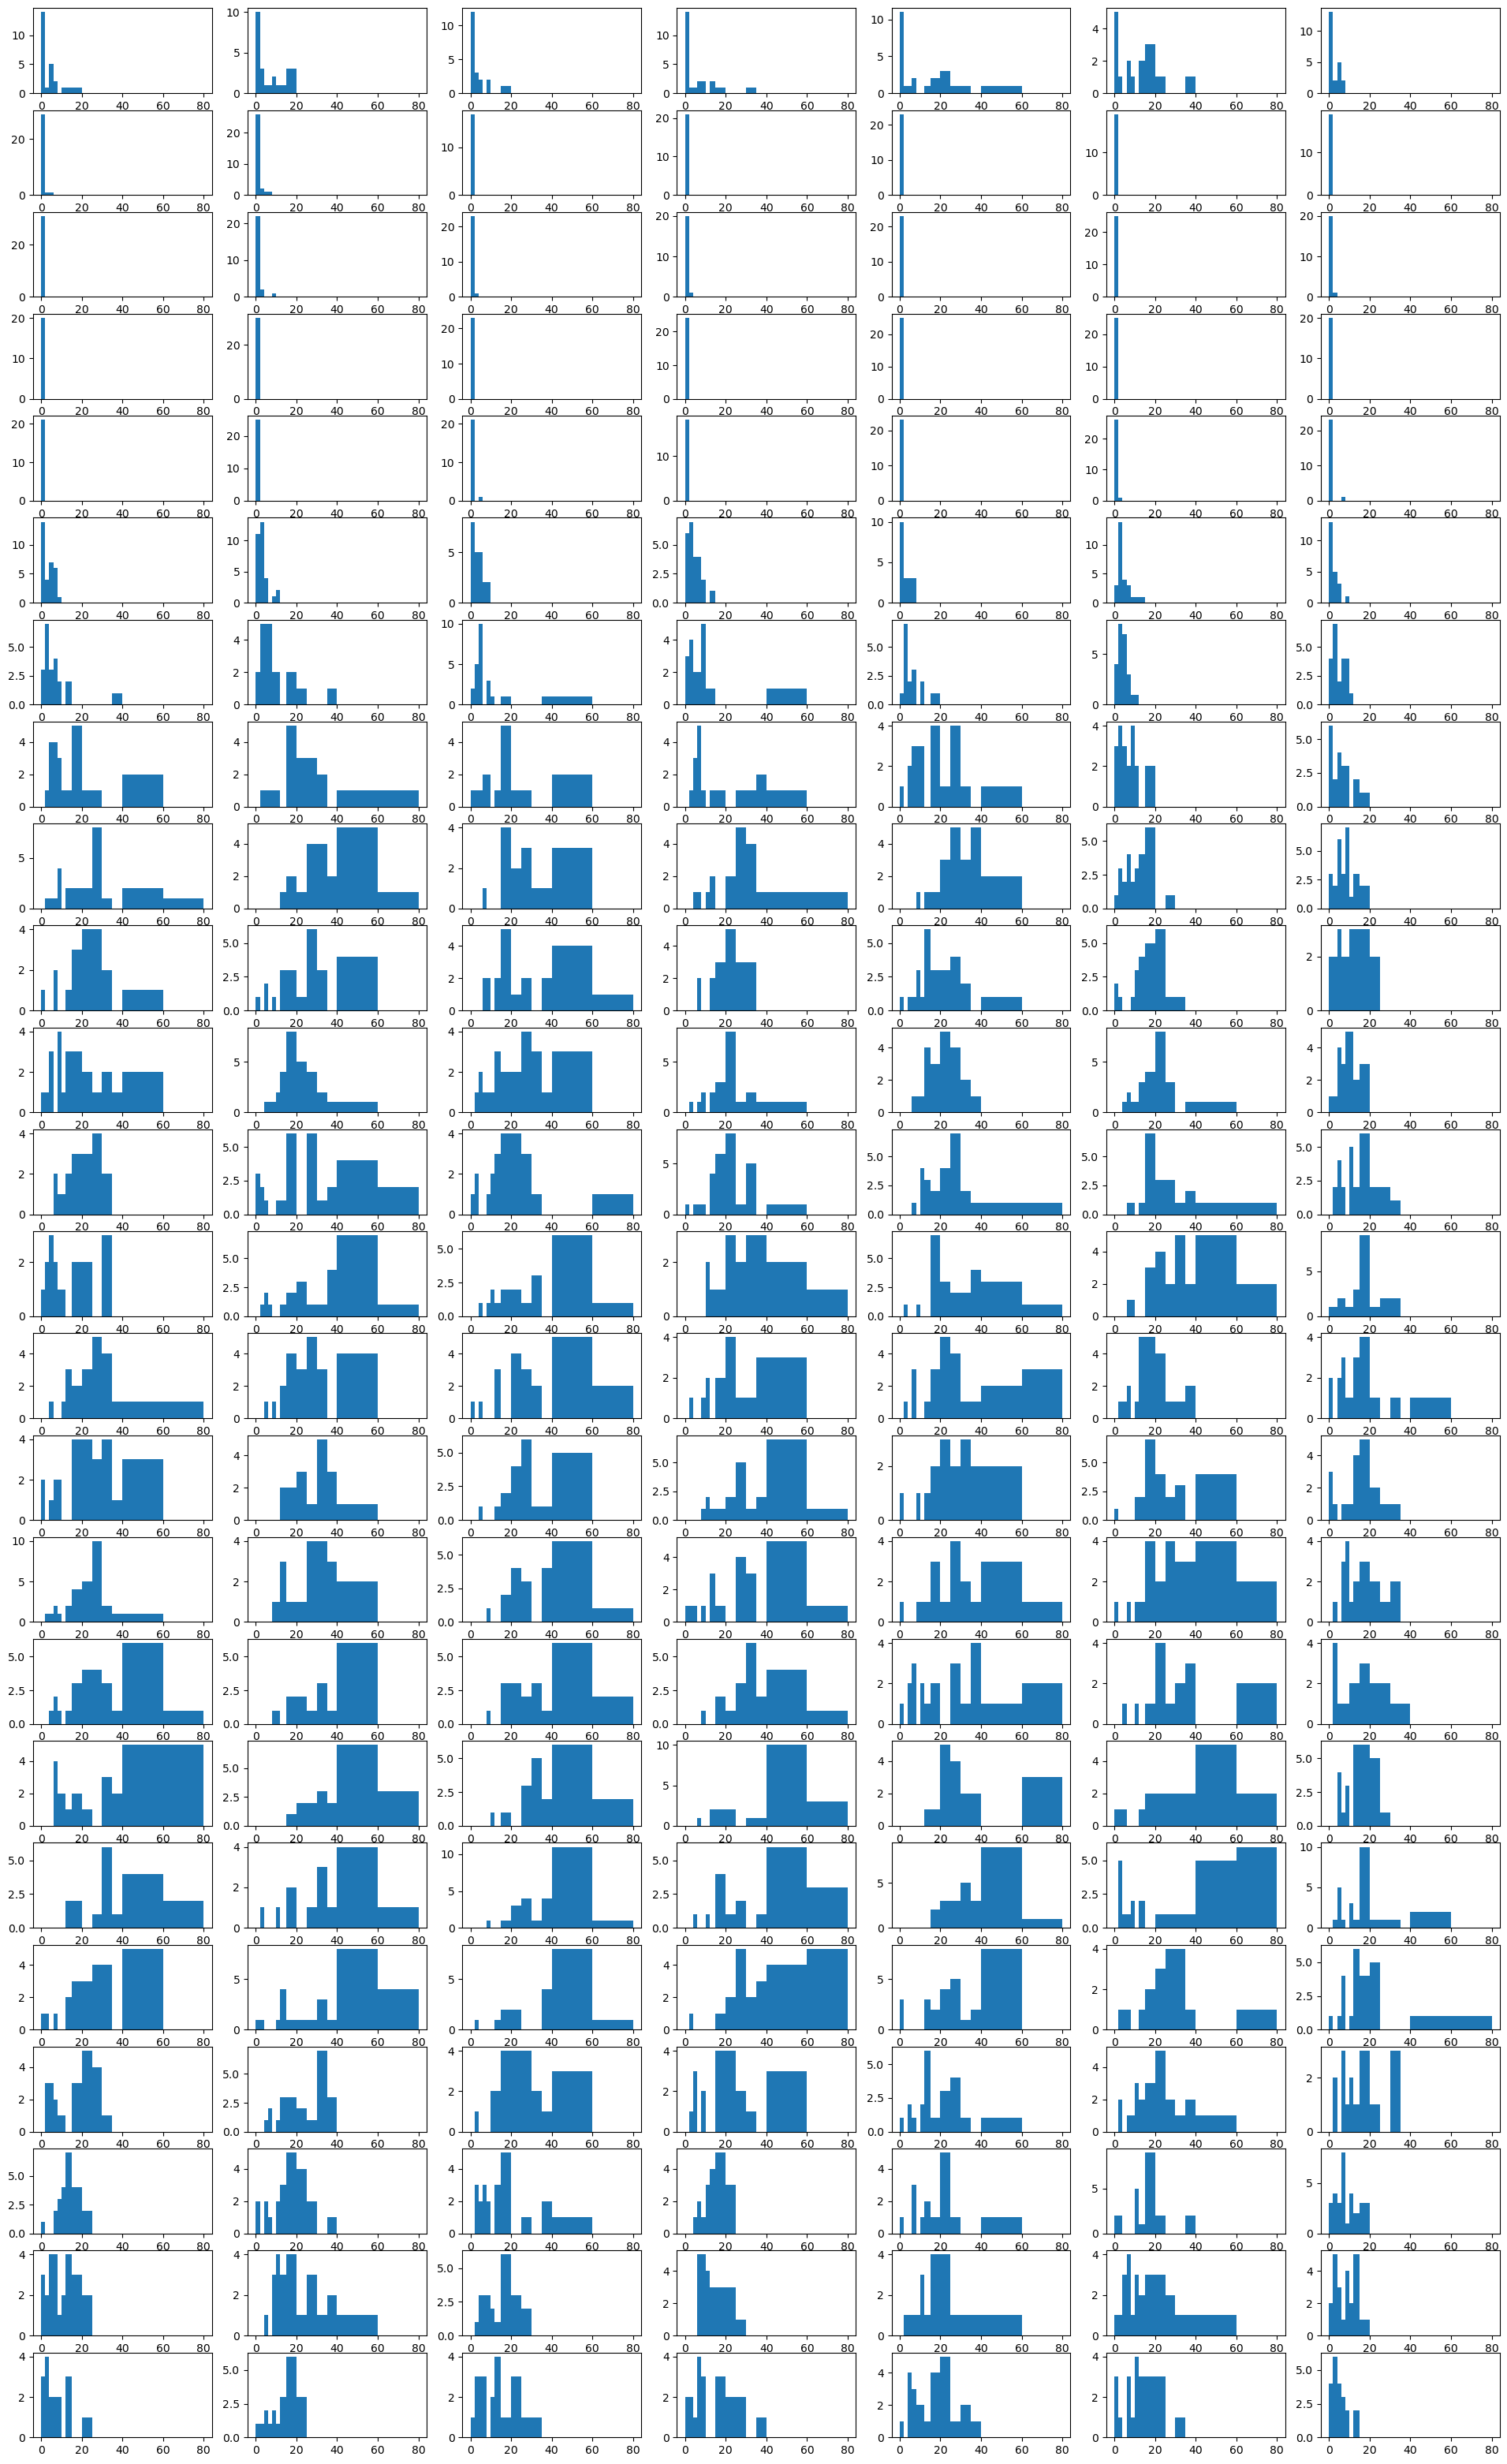

In [127]:
def plot_residual_hist(res_lower,bins =[0,2,4,6,8,10,12,15,20,25,30,35,40,60,80]):
    '''
    bins: 
    - [0,2,4,8,10,15,20,25,30,40,50,60,70,90,130,180]
    '''
    dic_residual_by_stations = {label: res_lower[torch.nonzero(T_cal == label,as_tuple = True)[0]][:,0,0] for label in T_cal.unique()}

    fig, axs = plt.subplots(24, 7,figsize=(24,40))
    for label in dic_residual_by_stations.keys():
        df = pd.DataFrame({label: dic_residual_by_stations[label]})
        label_i = int(label.item())
        i,j = label_i%24,label_i//24
        axs[i, j].hist(df[label],bins=bins)
    
plot_residual_hist(res_lower)

## Regardons la repartition des Upper-Residual, sur la station Ampère (postion 0), mais à travers tout les labels: 

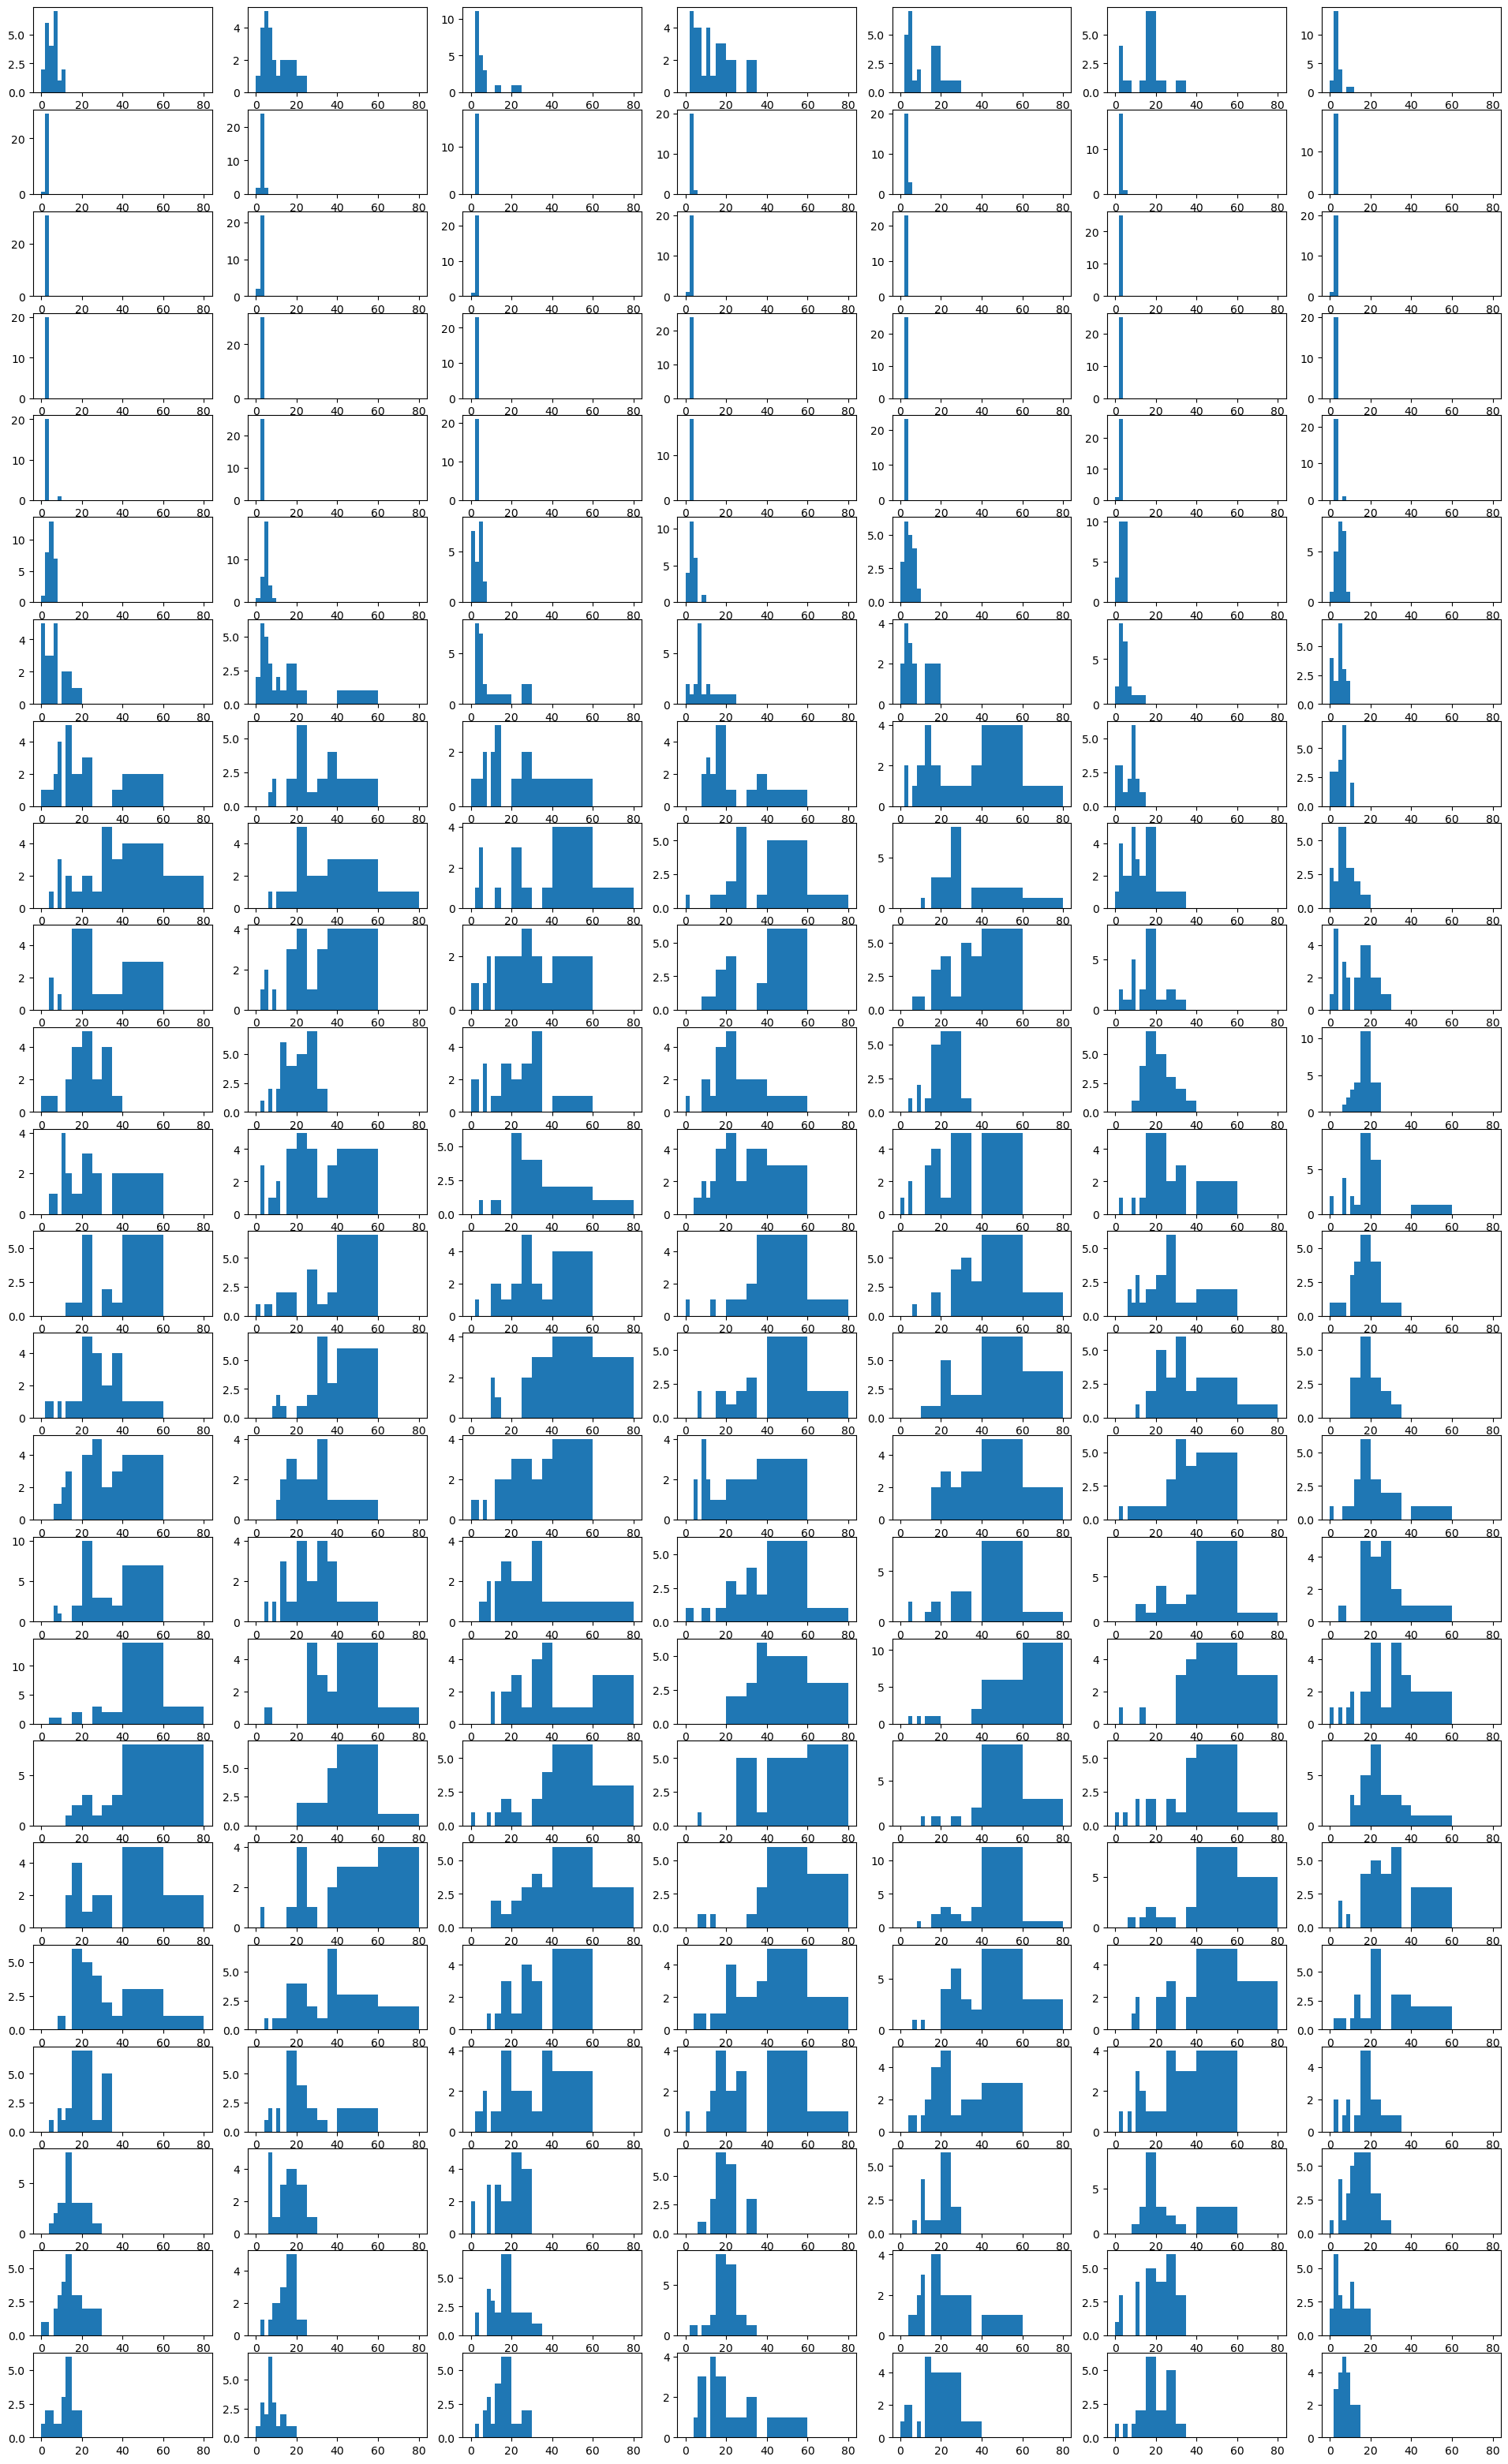

In [128]:
plot_residual_hist(res_upper)

## Regardons sur un unique Label (label 8 correspondant à Lundi 08:00):

array([[<Axes: title={'center': 'Ampère Victor Hugo'}>,
        <Axes: title={'center': 'Bellecour'}>,
        <Axes: title={'center': 'Brotteaux'}>,
        <Axes: title={'center': 'Charpennes'}>],
       [<Axes: title={'center': 'Cordeliers'}>,
        <Axes: title={'center': 'Croix Paquet'}>,
        <Axes: title={'center': 'Croix-Rousse'}>,
        <Axes: title={'center': 'Cuire'}>],
       [<Axes: title={'center': 'Cusset'}>,
        <Axes: title={'center': 'Debourg'}>,
        <Axes: title={'center': 'Flachet'}>,
        <Axes: title={'center': 'Foch'}>],
       [<Axes: title={'center': "Gare d'Oullins"}>,
        <Axes: title={'center': 'Gare de Vaise'}>,
        <Axes: title={'center': 'Gare de Vénissieux'}>,
        <Axes: title={'center': 'Garibaldi'}>],
       [<Axes: title={'center': 'Gorge de Loup'}>,
        <Axes: title={'center': 'Grange Blanche'}>,
        <Axes: title={'center': 'Gratte Ciel'}>,
        <Axes: title={'center': 'Guillotière'}>]], dtype=object)

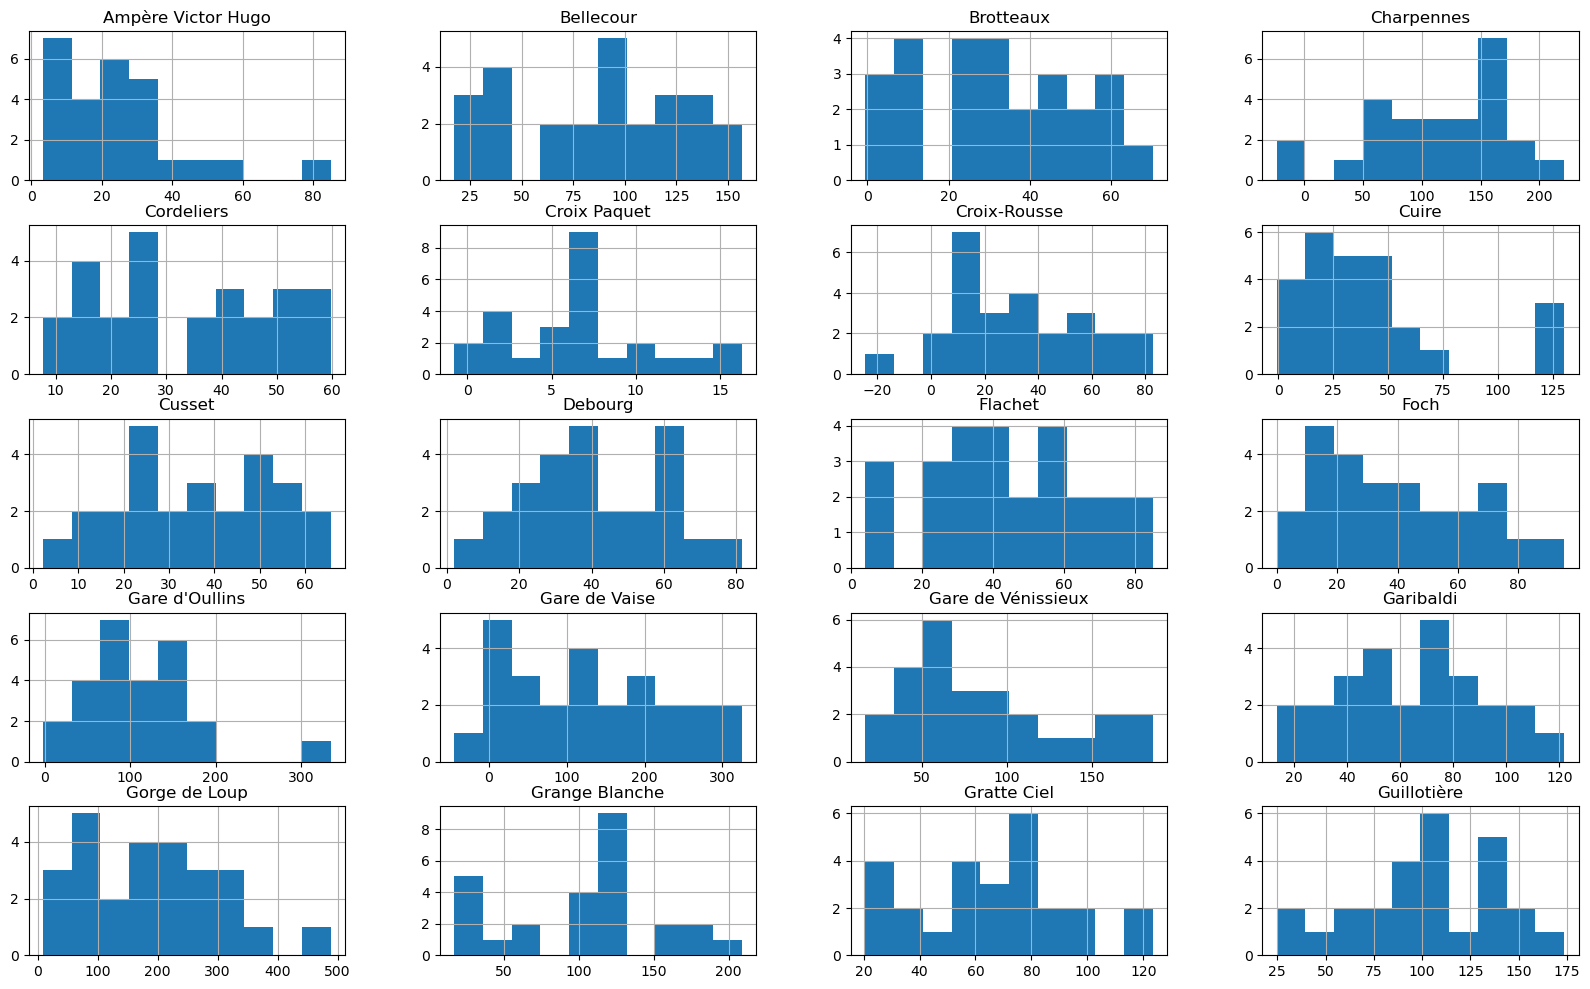

In [86]:
label = T_cal.unique()[8]
# Number of representation of label 'label' within Calibration DataSet
indices = torch.nonzero(T_cal == label,as_tuple = True)[0]

df_residual_by_stations = pd.DataFrame({c: res_lower[indices][:,k,0] for k,c in enumerate(trainer.dataset.columns)})
df_residual_by_stations.iloc[:,:20].hist(figsize=(20,12))

In [54]:
dic_label2Q = {}

#for label in T_cal.unique():
indices = torch.nonzero(T_cal == label,as_tuple = True)[0]
quantile_order = torch.Tensor([np.ceil((1 - trainer.args.alpha)*(indices.size(0)+1))/indices.size(0)]).to(trainer.args.device)  # Quantile for each class, so the quantile order is different as each class has a different length

In [ ]:
if False:
    # Get Confority scores: 
    if conformity_scores_type == 'max_residual':
        self.conformity_scores = torch.max(lower_q-Y_cal,Y_cal-upper_q).to(self.args.device) # Element-wise maximum        #'max(lower_q-y_b,y_b-upper_q)' is the quantile regression error function
    if conformity_scores_type == 'max_residual_plus_middle':
        str_info = str_info+ "\n|!| Conformity scores computation is not based on 'max(ql-y, y-qu)'"
        self.conformity_scores = torch.max(lower_q-Y_cal,Y_cal-upper_q) + ((lower_q>Y_cal)(upper_q<Y_cal))*(upper_q - lower_q)/2  # Element-wise maximum        #'max(lower_q-y_b,y_b-upper_q)' is the quantile regression error function
    # ...

    # Get Quantile:
    # If classic Calibration:
    if quantile_method == 'classic':  
        quantile_order = torch.Tensor([np.ceil((1 - alpha)*(X_cal.size(0)+1))/X_cal.size(0)]).to(self.args.device)
        #Q = torch.quantile(self.conformity_scores, quantile_order, dim = 0).to(self.device) #interpolation = 'higher'
        Q = get_higher_quantile(self.conformity_scores,quantile_order,device = self.args.device)
        output = Q

    # If Calibration by group of T_labels: 
    if quantile_method == 'compute_quantile_by_class':  # Calcul Higher Quantil for each calendar class. Several label can belongs to the same calendar class. The Quantile is computed through all residual of label of the same class
        calendar_class = torch.cat([t_cal for [_,_,_,t_cal] in data])
        dic_label2Q = {}
    # ...


        # Compute quantile for each calendar class : 
        nb_label_with_quantile_1 = 0
        for label in calendar_class.unique():
            indices = torch.nonzero(calendar_class == label,as_tuple = True)[0]
            quantile_order = torch.Tensor([np.ceil((1 - alpha)*(indices.size(0)+1))/indices.size(0)]).to(self.args.device)  # Quantile for each class, so the quantile order is different as each class has a different length
            quantile_order = min(torch.Tensor([1]).to(self.args.device),quantile_order)
            if quantile_order == 1: 
                nb_label_with_quantile_1 +=1
                #print(f"label {label} has only {indices.size(0)} elements in his class. We then use quantile order = 1")
            conformity_scores_i = self.conformity_scores[indices]
            scores_counts = conformity_scores_i.size(0)
            Q_i = get_higher_quantile(conformity_scores_i,quantile_order,device = self.args.device)
            #Q_i = torch.quantile(conformity_scores_i, quantile_order, dim = 0)#interpolation = 'higher'
            dic_label2Q[label.item()]= {'Q': Q_i,'count':scores_counts}

        str_info = str_info+ f"\nProportion of label with quantile order set to 1: {'{:.1%}'.format(nb_label_with_quantile_1/len(calendar_class.unique()))}"
        output = dic_label2Q
        

In [ ]:
# ==== Update Some Parameters:
config = model_perf['model'][best_trial]['args']
config['abs_path'] = f"{os.path.abspath(os.getcwd())}/"
config['device'] = 'cuda:0' if torch.cuda.is_available() else 'cpu'
config['K_fold'] = 6
args = get_parameters(config)
# ==== ....

# ==== Load un-trained model: 
Datasets,DataLoader_list,dic_class2rpz,nb_words_embedding,time_slots_labels,dic_rpz2class = load_init_trainer(folder_path,file_name,args)
(loss_function,Model_list,Optimizer_list,Scheduler_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding,dic_class2rpz,n_vertex = len(Datasets[0].columns))
multimodeltrainer = MultiModelTrainer(Datasets,Model_list,DataLoader_list,args,Optimizer_list,loss_function,Scheduler_list,args_embedding=args_embedding,dic_class2rpz=dic_class2rpz,show_figure=False)
# ==== ....

# ==== Load Trained Weight:
saved_checkpoint =  torch.load(best_model) if torch.cuda.is_available() else torch.load(best_model,map_location='cpu')
trainer = multimodeltrainer.Trainers[1]   # Fold1, très important car Fold0 a été pris pour le HP-Tuning. 
trainer.model.load_state_dict(saved_checkpoint['state_dict'])
# ===== ....

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0


/Users/romainrochas/opt/anaconda3/envs/ray/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00570927]
not reaching the requested tolerance 5.960464477539062e-07.
Use iteration 20 instead with accuracy 
0.004656454425472939.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/Users/romainrochas/opt/anaconda3/envs/ray/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[0.00465645]
not reaching the requested tolerance 5.960464477539062e-07.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/Users/romainrochas/opt/anaconda3/envs/ray/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[0.00225358]
not reaching the requested tolerance 5.960464477539062e-07.
Use iteration 21 instead with accuracy 
0.0022535813386284948.

  _, eigvec = lobpcg(XH_X, X, tol=t

<All keys matched successfully>

# Calibration sur un modèle qui est moins performant : 

In [6]:
# Ici on regarde la calibration classique, celle qui ne fait aucune distinction selon les 'classes' considérée.
Q = trainer.conformal_calibration(trainer.alpha,trainer.dataset,conformity_scores_type = 'max_residual',quantile_method = 'classic',print_info = True)
pi,pi_cqr = generate_bokeh(trainer,trainer.dataloader,trainer.dataset,Q,args,dic_class2rpz,station=0,show_figure = True,save_plot = False)

# Qui est totalement équivalent à :
#calibration_calendar_class = 0
#Q = trainer.conformal_calibration(trainer.alpha,trainer.dataset,conformity_scores_type = 'max_residual',quantile_method = 'compute_quantile_by_class',print_info = True,calibration_calendar_class = calibration_calendar_class)
#pi,pi_cqr = generate_bokeh(trainer,trainer.dataloader,trainer.dataset,Q,args,dic_class2rpz,station=0,show_figure = True,save_plot = False,calibration_calendar_class = calibration_calendar_class)

Loading BokehJS ...

### Calibration CQR autres : 

In [7]:
calibration_calendar_class = 3
for calibration_calendar_class in [1,2,3]:
    Q = trainer.conformal_calibration(trainer.alpha,trainer.dataset,conformity_scores_type = 'max_residual',quantile_method = 'compute_quantile_by_class',print_info = True,calibration_calendar_class = calibration_calendar_class)
    pi,pi_cqr = generate_bokeh(trainer,trainer.dataloader,trainer.dataset,Q,args,dic_class2rpz,station=0,show_figure = True,save_plot = False,calibration_calendar_class = calibration_calendar_class)


Proportion of label with quantile order set to 1: 0.0%


Loading BokehJS ...


Proportion of label with quantile order set to 1: 96.3%


Loading BokehJS ...


Proportion of label with quantile order set to 1: 0.0%


Loading BokehJS ...

## Pour l'instant, rien de très convainquant.

# Quantraffic

In [8]:
# ==== QuanTraffic Calibration : 
# Load Y_pred_calibration1 and Y_pred_calibration2
split_prop = 0.5
nb_quantiles = 99
n_lambda = 50 #41 
lambda_list = np.arange(0,n_lambda)/n_lambda

Q_calibration_table = get_QuanTraffic_calibration_table(trainer,split_prop,nb_quantiles,lambda_list)

In [9]:
pi,pi_cqr = generate_bokeh(trainer,trainer.dataloader,trainer.dataset,Q_calibration_table.unsqueeze(0),args,dic_class2rpz,station=0,show_figure = True,save_plot = False)

Loading BokehJS ...

# `Ici aussi les calibrations ne semble pas très bonne. Au moins cette fois-ci les intervalles sont plus restreint. Peut être que c'est utile qu'a partir du moment où le model n'est pas très bien entrainé. Mais cela ne reste pas très convaincant...`